In [1]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/fileonssd/runway-dataset/lard-dataset
/home/yeli/workspace/lard/lard-detection


# CSV元数据 - 读取(训练1 测试合成1 测试真实3)
科研图表常用颜色：
这些颜色在科研领域中较为常见，用于表示不同的数据序列。
- 蓝色：#1f77b4
- 橙色：#ff7f0e
- 绿色：#2ca02c
- 红色：#d62728
- 紫色：#9467bd
- 棕色：#8c564b

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
plt.rcParams['text.usetex'] = False

# 训练数据信息
print("Training 训练")
data_train = pd.read_csv(
    f"{ROOT_PROJECT}/datasets/LARD_train.csv",
    sep=';')
data_train['airport'] = data_train['airport'].replace('SRLI', 'SLTR')  # 数据集错误
print(data_train.columns.to_list())

# 测试(synth)数据信息
print("Test 测试")
data_test_synth = pd.read_csv(
    f"{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_synth/LARD_test_synth.csv",
    sep=';')
print(data_test_synth.columns.to_list())

# 测试(real-nominal-cases)数据信息
data_test_real_nc = pd.read_csv(
    f"{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_nominal_cases/LARD_test_real_nominal_cases.csv",
    sep=';')  # 无watermark_height
print(data_test_real_nc.columns.to_list())

# 测试(real-edge-cases)数据信息
data_test_real_ec = pd.read_csv(
    f"{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_edge_cases/LARD_test_real_edge_cases.csv",
    sep=';')  # 无watermark_height
print(data_test_real_ec.columns.to_list())


训练
['image', 'height', 'width', 'type', 'original_dataset', 'scenario', 'airport', 'runway', 'time_to_landing', 'weather', 'night', 'time', 'slant_distance', 'along_track_distance', 'height_above_runway', 'lateral_path_angle', 'vertical_path_angle', 'yaw', 'pitch', 'roll', 'watermark_height', 'x_A', 'y_A', 'x_B', 'y_B', 'x_C', 'y_C', 'x_D', 'y_D']
测试
['image', 'height', 'width', 'type', 'original_dataset', 'scenario', 'airport', 'runway', 'time_to_landing', 'weather', 'night', 'time', 'slant_distance', 'along_track_distance', 'height_above_runway', 'lateral_path_angle', 'vertical_path_angle', 'yaw', 'pitch', 'roll', 'x_A', 'y_A', 'x_B', 'y_B', 'x_C', 'y_C', 'x_D', 'y_D', 'watermark_height']
['image', 'height', 'width', 'type', 'original_dataset', 'scenario', 'airport', 'runway', 'time_to_landing', 'weather', 'night', 'time', 'slant_distance', 'along_track_distance', 'height_above_runway', 'lateral_path_angle', 'vertical_path_angle', 'yaw', 'pitch', 'roll', 'watermark_height', 'x_A', 'y

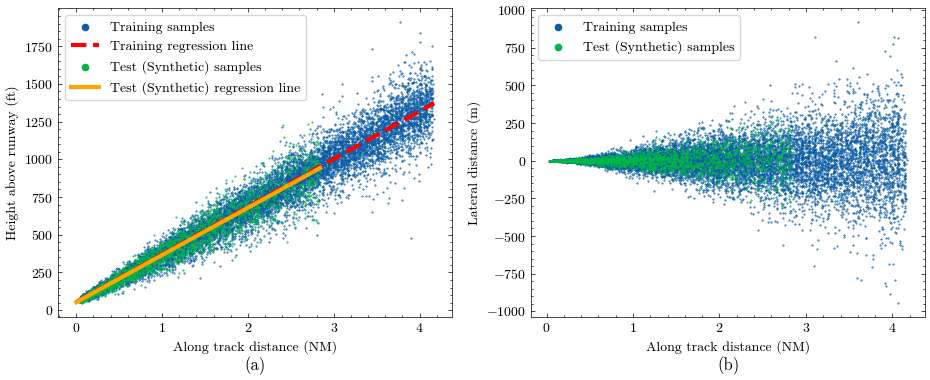

In [3]:
# fit training data, 训练数据拟合
coefficients = np.polyfit(
    data_train.along_track_distance,
    data_train.height_above_runway,
    deg=1)
polynomial = np.poly1d(coefficients)
x_fit_train = np.linspace(0, data_train.along_track_distance.max(), 100)
y_fit_train = polynomial(x_fit_train)

# fit synthetic data, 测试(synth)数据拟合
coefficients = np.polyfit(
    data_test_synth.along_track_distance,
    data_test_synth.height_above_runway,
    deg=1)
polynomial = np.poly1d(coefficients)
x_fit_test_synth = np.linspace(
    0, data_test_synth.along_track_distance.max(), 100)
y_fit_test_synth = polynomial(x_fit_test_synth)

# along glide slop 绘制下滑道散点图
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 4), dpi=100)
ax[0].scatter(
    x=data_train.along_track_distance,
    y=data_train.height_above_runway,
    s=0.2, label='Training samples')
ax[0].plot(
    x_fit_train, y_fit_train,
    label='Training regression line',
    color='red', linewidth=3, linestyle='dashed')
ax[0].scatter(
    x=data_test_synth.along_track_distance,
    y=data_test_synth.height_above_runway,
    s=0.2,
    label='Test (Synthetic) samples')
ax[0].plot(
    x_fit_test_synth,
    y_fit_test_synth,
    label='Test (Synthetic) regression line',
    color='orange',
    linewidth=3)

ax[0].set_xlabel('Along track distance (NM)')
ax[0].set_ylabel('Height above runway (ft)')
ax[0].set_title('(a)', y=-0.2)
ax[0].legend(loc='best', frameon=True, scatterpoints=1, markerscale=10)


# along localizer 沿航向道分布
ax[1].scatter(
    x=data_train.along_track_distance, 
    y=data_train.along_track_distance*np.tan(np.radians(data_train.lateral_path_angle))*1852, 
    s=0.2, 
    label='Training samples')
ax[1].scatter(
    x=data_test_synth.along_track_distance, 
    y=data_test_synth.along_track_distance*np.tan(np.radians(data_test_synth.lateral_path_angle))*1852, 
    s=0.2, 
    label='Test (Synthetic) samples')

ax[1].set_xlabel('Along track distance (NM)')
ax[1].set_ylabel('Lateral distance (m)')
ax[1].set_title('(b)', y=-0.2)
ax[1].legend(loc='best', frameon=True, scatterpoints=1, markerscale=10)

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/samples_glide_slope_and_localizer.svg',
    dpi=600, bbox_inches='tight')
plt.show()


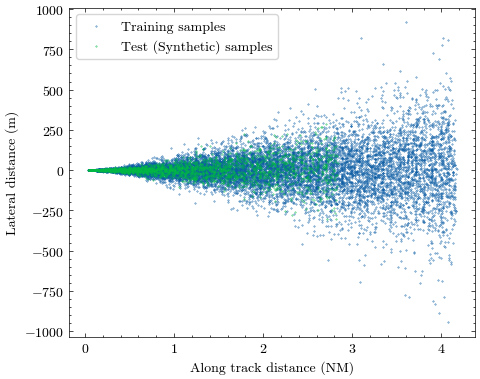

In [4]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(
    x=data_train.along_track_distance, 
    y=data_train.along_track_distance*np.tan(np.radians(data_train.lateral_path_angle))*1852, 
    s=0.1, 
    label='Training samples')

plt.scatter(
    x=data_test_synth.along_track_distance, 
    y=data_test_synth.along_track_distance*np.tan(np.radians(data_test_synth.lateral_path_angle))*1852, 
    s=0.1, 
    label='Test (Synthetic) samples')

plt.xlabel('Along track distance (NM)')
plt.ylabel('Lateral distance (m)')
plt.legend(loc='best', frameon=True)

plt.tight_layout()

# CSV元数据 - 合成样本下滑道位置分布图

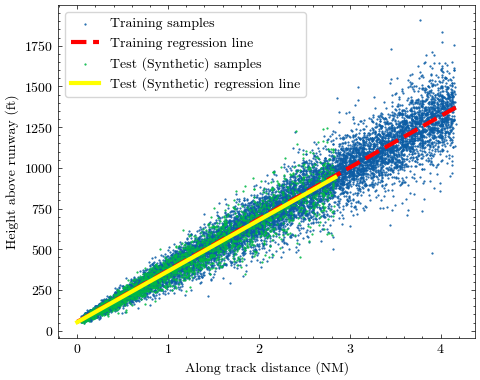

In [5]:
# 训练数据拟合
coefficients = np.polyfit(
    data_train.along_track_distance,
    data_train.height_above_runway,
    deg=1)
polynomial = np.poly1d(coefficients)
x_fit_train = np.linspace(0, data_train.along_track_distance.max(), 100)
y_fit_train = polynomial(x_fit_train)

# 测试(synth)数据拟合
coefficients = np.polyfit(
    data_test_synth.along_track_distance,
    data_test_synth.height_above_runway,
    deg=1)
polynomial = np.poly1d(coefficients)
x_fit_test_synth = np.linspace(
    0, data_test_synth.along_track_distance.max(), 100)
y_fit_test_synth = polynomial(x_fit_test_synth)

# 绘制下滑道散点图
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(
    x=data_train.along_track_distance,
    y=data_train.height_above_runway,
    s=0.3, label='Training samples')
plt.plot(
    x_fit_train, y_fit_train,
    label='Training regression line',
    color='red', linewidth=3, linestyle='dashed')
plt.scatter(
    x=data_test_synth.along_track_distance,
    y=data_test_synth.height_above_runway,
    s=0.3,
    label='Test (Synthetic) samples')
plt.plot(
    x_fit_test_synth,
    y_fit_test_synth,
    label='Test (Synthetic) regression line',
    color='yellow',
    linewidth=3)

plt.xlabel('Along track distance (NM)')
plt.ylabel('Height above runway (ft)')
plt.legend(loc='best', frameon=True)

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/samples_glide_slope.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/samples_glide_slope.svg',
    dpi=600, bbox_inches='tight')
plt.show()


# CSV元数据 - 样本数量统计

In [6]:
# 记录在CSV中的样本数
# 1. 检查是否与图像文件对应
# 2. 检查是否与dataloader一致

num_train = data_train.shape[0]
num_test_synth = data_test_synth.shape[0]
num_test_real_ec = data_test_real_ec.shape[0]
num_test_real_nc = data_test_real_nc.shape[0]
num_test_real = num_test_real_ec + num_test_real_nc
num_test = num_test_synth + num_test_real
num = num_train + num_test

print(f"训练集(train)样本数：\t\t\t{num_train}")
print(f"测试集(synth)样本数：\t\t\t{num_test_synth}")
print(f"测试集(real-nominal-cases)样本数：\t{num_test_real_nc}")
print(f"测试集(real-edge-cases)样本数：\t\t{num_test_real_ec}")

print("========")
print(f"训练集(train)样本数：\t\t\t{num_train}")
print(f"测试集(synth)样本数：\t\t\t{num_test_synth}")
print(f"测试集(real)样本数：\t\t\t{num_test_real}")
print(f"测试集(test)样本数：\t\t\t{num_test}")
print(f"总样本(total)数量：\t\t\t{num}")


训练集(train)样本数：			14433
测试集(synth)样本数：			2212
测试集(real-nominal-cases)样本数：	1500
测试集(real-edge-cases)样本数：		311
训练集(train)样本数：			14433
测试集(synth)样本数：			2212
测试集(real)样本数：			1811
测试集(test)样本数：			4023
总样本(total)数量：			18456


# 各机场可用样本数量统计

In [7]:
airport_train = data_train.airport.value_counts().sort_index()
airport_test_synth = data_test_synth.airport.value_counts().sort_index()
airport_test_real_ec = data_test_real_ec.airport.value_counts().sort_index()
airport_test_real_nc = data_test_real_nc.airport.value_counts().sort_index()

num_train_airport = airport_train.shape[0]
num_test_synth_airport = airport_test_synth.shape[0]
num_test_real_ec_airport = airport_test_real_ec.shape[0]
num_test_real_nc_airport = airport_test_real_nc.shape[0]
num_test_real_airport = num_test_real_ec_airport + num_test_real_nc_airport
num_test_airport = num_test_synth_airport + num_test_real_airport
num_airport = num_train_airport + num_test_airport

print(f"训练集(train)机场数：\t\t\t{num_train_airport}")
print(f"测试集(synth)机场数：\t\t\t{num_test_synth_airport}")
print(f"测试集(real-edge-cases)机场数：\t\t{num_test_real_ec_airport}")
print(f"测试集(real-nominal-cases)机场数：\t{num_test_real_nc_airport}")

print("========")
print(f"训练集(train)机场数：\t\t\t{num_train_airport}")
print(f"测试集(synth)机场数：\t\t\t{num_test_synth_airport}")
print(f"测试集(real)机场数：\t\t\t{num_test_real_airport}")
print(f"测试集(test)机场数：\t\t\t{num_test_airport}")
print(f"总机场(total)数量：\t\t\t{num_airport}")


训练集(train)机场数：			15
测试集(synth)机场数：			40
测试集(real-edge-cases)机场数：		34
测试集(real-nominal-cases)机场数：	95
训练集(train)机场数：			15
测试集(synth)机场数：			40
测试集(real)机场数：			129
测试集(test)机场数：			169
总机场(total)数量：			184


# 绘制 - 各数据集中不同机场包含的样本数

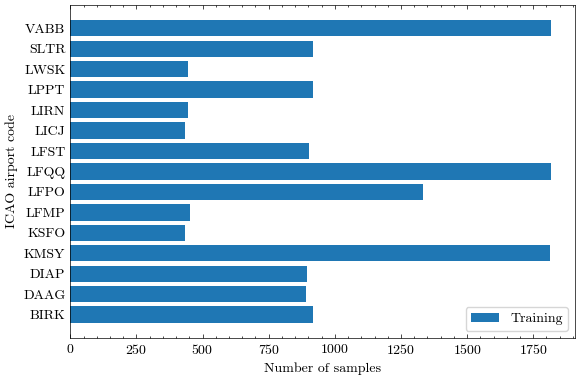

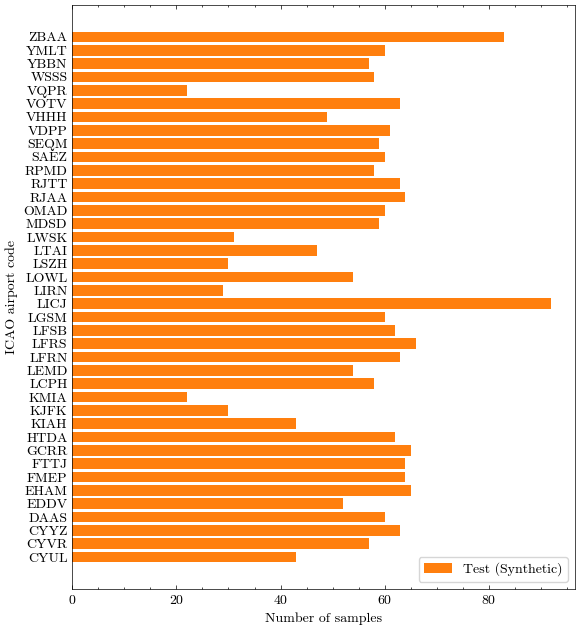

In [8]:
# 绘制训练集机场数量
plt.figure(figsize=(6, 4), dpi=100)
plt.barh(
    y=airport_train.index,
    width=airport_train.values,
    label='Training', color='#1f77b4')
plt.ylabel('ICAO airport code')
plt.xlabel('Number of samples')
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.legend(loc='best', frameon=True)

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/samples_training.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()


# 绘制合成(synth)测试集机场数量
plt.figure(figsize=(6, 6.5), dpi=100)
plt.barh(
    y=airport_test_synth.index,
    width=airport_test_synth.values,
    label='Test (Synthetic)', color='#ff7f0e')
plt.ylabel('ICAO airport code')
plt.xlabel('Number of samples')
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.legend(loc='best', frameon=True)

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/samples_test_synth.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

# 实际(real)测试集机场数量过多 不再绘制

# 统计 - 各数据集可用机场/可用跑道

In [9]:
# 各数据集跑道统计
runway_train = data_train[['airport', 'runway', 'image']].groupby(['airport', 'runway']).count()
runway_test_synth = data_test_synth[['airport', 'runway', 'image']].groupby(['airport', 'runway']).count()
runway_test_real_ec = data_test_real_ec[['airport', 'runway', 'image']].groupby(['airport', 'runway']).count()
runway_test_real_nc = data_test_real_nc[['airport', 'runway', 'image']].groupby(['airport', 'runway']).count()

num_train_runway = runway_train.shape[0]
num_test_synth_runway = runway_test_synth.shape[0]
num_test_real_ec_runway = runway_test_real_ec.shape[0]
num_test_real_nc_runway = runway_test_real_nc.shape[0]
num_test_real_runway = num_test_real_ec_runway + num_test_real_nc_runway
num_test_runway = num_test_synth_runway + num_test_real_runway
num_runway = num_train_runway + num_test_runway

print(f"训练集(train)跑道数：\t\t\t{num_train_runway}")
print(f"测试集(synth)跑道数：\t\t\t{num_test_synth_runway}")
print(f"测试集(real-edge-cases)跑道数：\t\t{num_test_real_ec_runway}")
print(f"测试集(real-nominal-cases)跑道数：\t{num_test_real_nc_runway}")
print("========")
print(f"训练集(train)跑道数：\t\t\t{num_train_runway}")
print(f"测试集(synth)跑道数：\t\t\t{num_test_synth_runway}")
print(f"测试集(real)跑道数：\t\t\t{num_test_real_runway}")
print(f"测试集(test)跑道数：\t\t\t{num_test_runway}")
print(f"总跑道(total)数量：\t\t\t{num_runway}")

训练集(train)跑道数：			32
测试集(synth)跑道数：			79
测试集(real-edge-cases)跑道数：		40
测试集(real-nominal-cases)跑道数：	115
训练集(train)跑道数：			32
测试集(synth)跑道数：			79
测试集(real)跑道数：			155
测试集(test)跑道数：			234
总跑道(total)数量：			266


# 找出测试集和训练集的共有机场

In [10]:
def find_common_and_diff(list1, list2):

    # 将列表转换为集合
    set1 = set(list1)
    set2 = set(list2)

    # 找到共同包含机场
    common_items = set1.intersection(set2)
    # 找到不同的项目
    different_items = set1.symmetric_difference(set2)

    return list(common_items), list(different_items)


# 各数据集机场列表
airport_list_train = airport_train.index.to_list()
airport_list_test_synth = airport_test_synth.index.to_list()
airport_list_test_real_ec = airport_test_real_ec.index.to_list()
airport_list_test_real_nc = airport_test_real_nc.index.to_list()

comm, diff = find_common_and_diff(airport_list_train, airport_list_test_synth)
print("训练集和测试集(synth)共同包含机场:", comm)

comm, diff = find_common_and_diff(airport_list_train, airport_list_test_real_ec)
print("训练集和测试集(ec)共同包含机场:", comm)

comm, diff = find_common_and_diff(airport_list_train, airport_list_test_real_nc)
print("训练集和测试集(nc)共同包含机场:", comm)

训练集和测试集(synth)共同包含机场: ['LWSK', 'LICJ', 'LIRN']
训练集和测试集(ec)共同包含机场: ['LFPO', 'KSFO']
训练集和测试集(nc)共同包含机场: ['LICJ', 'KSFO', 'LPPT', 'LIRN']


# 搜索 - 各机场详细信息

In [11]:
# ! wget -O {ROOT_PROJECT}/datasets/airports.csv https://davidmegginson.github.io/ourairports-data/airports.csv

In [12]:
import pandas as pd

# 加载机场数据库
db = pd.read_csv(f'{ROOT_PROJECT}/datasets/airports.csv')  # https://ourairports.com/data/
print(db.shape, db.columns.to_list())
db.head()

(78320, 18) ['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg', 'elevation_ft', 'continent', 'iso_country', 'iso_region', 'municipality', 'scheduled_service', 'gps_code', 'iata_code', 'local_code', 'home_link', 'wikipedia_link', 'keywords']


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [13]:
def search_db(db, airport_list, filename):
    
    coi = ['ident', 'name', 'type', 'iso_country', 'latitude_deg', 'longitude_deg', 'elevation_ft']
    db_pairup = db[db.ident.isin(airport_list)].sort_values('ident').reset_index(drop=True)[coi]
    db_pairup.to_csv(f'{ROOT_PROJECT}/results/tables/eda/{filename}.csv', index=False)
    
    # check if missing
    airport_list_founded = db_pairup.ident.to_list()
    list_not_found = list(set(airport_list) ^ set(airport_list_founded))

    print(f"{filename} \t 应有机场：{len(airport_list)}, 找到机场：{len(airport_list_founded)}")
    if len(list_not_found):
        print(f"未找到机场：{list_not_found}")

    return db_pairup


# 在数据库中检索LARD数据集中机场的信息并保存为csv文件
info_train = search_db(db, airport_list_train, 'airport_info_training')
info_test_synth = search_db(db, airport_list_test_synth, 'airport_info_test_synth')
info_test_real_ec = search_db(db, airport_list_test_real_ec, 'airport_info_test_real_ec')
info_test_real_nc = search_db(db, airport_list_test_real_nc, 'airport_info_test_real_nc')


airport_info_training 	 应有机场：15, 找到机场：15
airport_info_test_synth 	 应有机场：40, 找到机场：40
airport_info_test_real_ec 	 应有机场：34, 找到机场：33
未找到机场：['UNKW']
airport_info_test_real_nc 	 应有机场：95, 找到机场：95


# 统计所有机场大小情况

In [14]:
# 整合全部信息
info_all = pd.concat([info_train, info_test_synth, info_test_real_ec, info_test_real_nc], axis=0)
info_all.drop_duplicates(inplace=True)

print(f"数据集共涉{info_all.shape[0]}个不同机场")

for index, value in info_all['type'].value_counts().items():
    print(f"机场类型：{index}, 机场数量: {value}")

# https://ourairports.com/help/
# Large airport:	 Land airport with scheduled major airline service with millions of passengers/year, or major military base).
# Medium airport:    Land airport with scheduled regional airline service, or regular general aviation or military traffic.
# Small airport:	 Land airport with little or no scheduled service, light general aviation traffic.
# Closed:            Any type of airport that's no longer operational.

数据集共涉138个不同机场
机场类型：large_airport, 机场数量: 100
机场类型：medium_airport, 机场数量: 37
机场类型：small_airport, 机场数量: 1


# 绘图 - 各数据集机场地理分布

In [15]:
from pyecharts.charts import Geo
from pyecharts import options as opts
from pyecharts.globals import GeoType

# 创建 Geo 实例
geo = Geo(
    init_opts=opts.InitOpts(
        width="800px", height="450px", bg_color="white",
        theme="light", renderer="svg"
    )
)

# 添加地图
geo.add_schema(maptype="world", zoom=1.2, is_roam=False)

# 添加机场位置
for info in [info_train, info_test_synth, info_test_real_ec, info_test_real_nc]:
    for _, row in info.iterrows():
        geo.add_coordinate(
            row['ident'], row['longitude_deg'], row['latitude_deg'])

# 绘制标记点
# 训练集
data_pair = [(z) for z in zip(info_train.ident, np.ones(info_train.shape[0]))]
geo.add(
    "Airports in training dataset",
    data_pair,
    # type_=GeoType.EFFECT_SCATTER,
    symbol_size=11,
)

# 测试集(synth)
data_pair = [(z) for z in zip(info_test_synth.ident, np.ones(info_test_synth.shape[0]))]
geo.add(
    "Airports in test dataset (Synthetic)",
    data_pair,
    symbol_size=9,
)

# 测试集(edge-cases)
data_pair = [(z) for z in zip(info_test_real_ec.ident, np.ones(info_test_real_ec.shape[0]))]
geo.add(
    "Airports in test dataset (Real edge)",
    data_pair,
    symbol_size=7,
)

# 测试集(normal-cases)
data_pair = [(z) for z in zip(info_test_real_nc.ident, np.ones(info_test_real_nc.shape[0]))]
geo.add(
    "Airports in test dataset (Real nominal)",
    data_pair,
    symbol_size=5,
)

# 参数设置
geo.set_series_opts(
    label_opts=opts.LabelOpts(is_show=False)
)
geo.set_global_opts(
    legend_opts=opts.LegendOpts(
        pos_top='bottom',
        pos_left='left',
        orient='vertical',
        background_color='white',
        textstyle_opts=opts.TextStyleOpts(
            font_family='Times New Roman', font_size=13)
    )
)

def add_download_link(path):
    # 增加下载svg的链接
    code_to_insert = """
    <a id="download" href="">下载SVG</a>
    <script>
    const a = window.document.querySelector('#download')
    a.addEventListener('click',()=>{
        const content = document.querySelector('svg').outerHTML
        const blob= new Blob([content], {type: 'xml/svg'})
        a.href = URL.createObjectURL(blob)
        a.download = 'airport_map.svg'
    })
    </script>
    """
    with open(path, "r", encoding="utf-8") as file:
        html_content = file.read()

    insert_position = html_content.find("</body>")
    if insert_position != -1:
        new_html_content = html_content[:insert_position] + \
            code_to_insert + html_content[insert_position:]
        with open(path, "w", encoding="utf-8") as file:
            file.write(new_html_content)
    else:
        print("Could not find </body> tag in the HTML file.")

# 显示图表
path = f'{ROOT_PROJECT}/results/figs/eda/airport_map.html'
geo.render(path)
add_download_link(path)
geo.render_notebook()


# 统计 - 各数据集样本分布（按照跑道入口距离或时间）

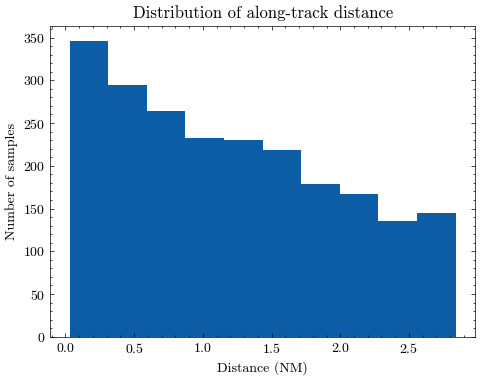

Max value: 2.84 NM
Min value: 0.03 NM


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 合成测试集
plt.figure(figsize=(5, 4), dpi=100)
data_test_synth.along_track_distance.plot(kind='hist')
plt.title('Distribution of along-track distance')
plt.xlabel('Distance (NM)')
plt.ylabel('Number of samples')
plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/distribution_of_along_track_distance.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

max_value = data_test_synth.along_track_distance.max()
min_value = data_test_synth.along_track_distance.min()

print(f'Max value: {max_value} NM')
print(f'Min value: {min_value} NM')



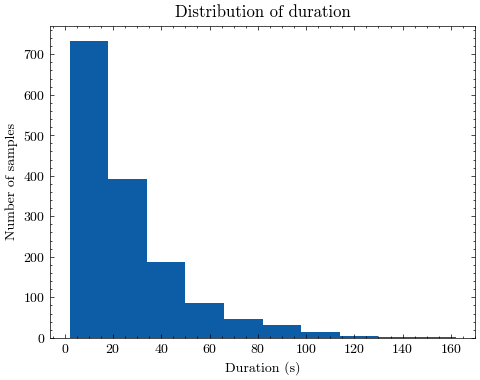

Max value: 162 seconds
Min value: 2 seconds


In [17]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 4), dpi=100)
data_test_real_nc.time_to_landing.plot(kind='hist')
plt.title('Distribution of duration')
plt.xlabel('Duration (s)')
plt.ylabel('Number of samples')
plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/distribution_of_real_nominal_time_to_landing.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

max_value = data_test_real_nc.time_to_landing.max()
min_value = data_test_real_nc.time_to_landing.min()

print(f'Max value: {max_value} seconds')
print(f'Min value: {min_value} seconds')


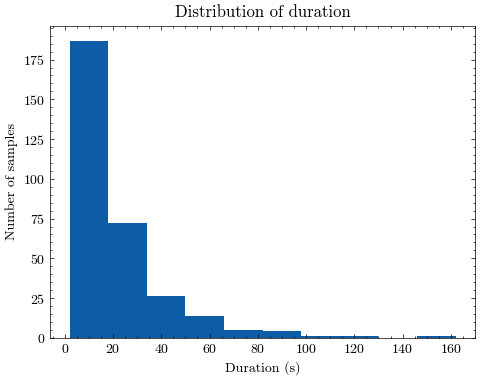

Max value: 162 seconds
Min value: 2 seconds


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4), dpi=100)
data_test_real_ec.time_to_landing.plot(kind='hist')
plt.title('Distribution of duration')
plt.xlabel('Duration (s)')
plt.ylabel('Number of samples')
plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/distribution_of_real_edge_time_to_landing.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

max_value = data_test_real_ec.time_to_landing.max()
min_value = data_test_real_ec.time_to_landing.min()

print(f'Max value: {max_value} seconds')
print(f'Min value: {min_value} seconds')
